
# MobileNet V1: A PyTorch Tutorial



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 in PyTorch
- Use transfer learning for better accuracy


![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [ ]:
# Importing libraries
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import transforms
from torch.optim import Optimizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Tuple, List
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchvision
import torch
import time
import os

Check your device. We recommend using GPU. You can use GPU with google colab.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [ ]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)
    return gamma * x_normalized + beta

We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [ ]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Create train data loader without shuffle with just half of the data
half_train_set = Subset(train_set, list(range(len(train_set) // 2)))
train_loader = DataLoader(half_train_set, batch_size=128, shuffle=False)

val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

# Create test
test_loader = DataLoader(val_set, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### **Explain what we did in transfor train and tranform test:**

We did data augmentation and normalization on the input data with thses steps:
- cropping image randomly and resizing to 224x224. the scale of crop is between 0.5 and 1. This technique helps model to generalize better.
- Flipping the image randomly with probability of 0.5. This aslo helps the model to prevent overfitting.
- Finally wr convert the image to a tensor and scale the pixel values to [0, 1] and then normailze them in each channel.

On test we only do resizing to 224x224, converting to tensor and normalization. These are for consistency training and test data to have a better performance.

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

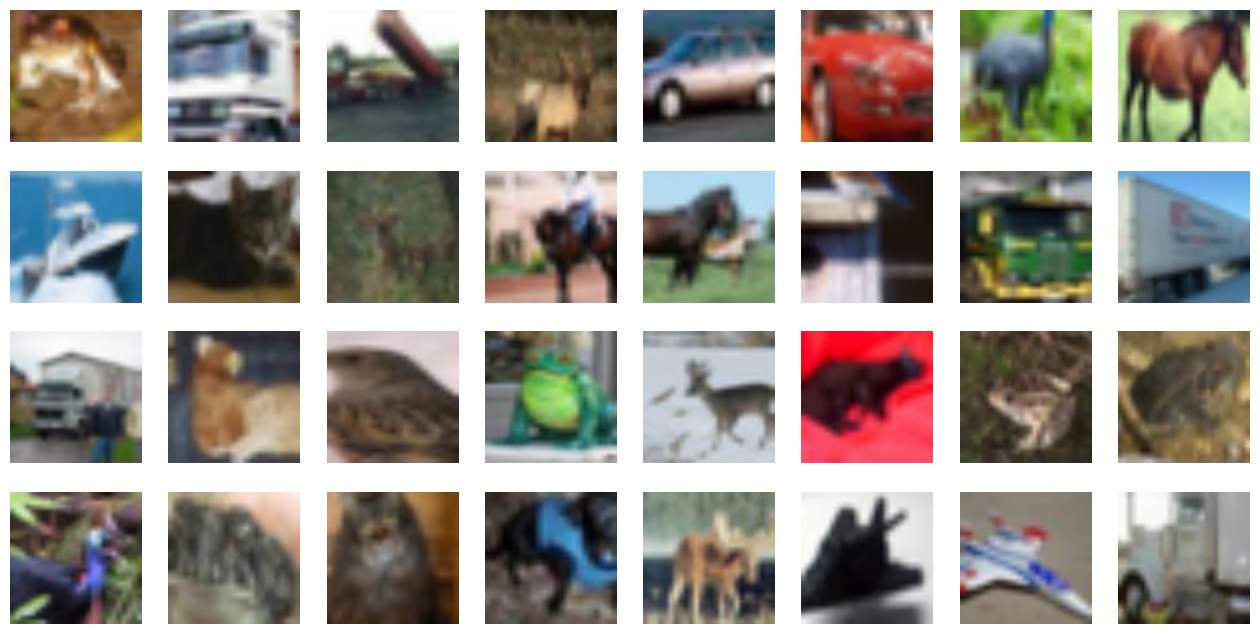

Labels are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])


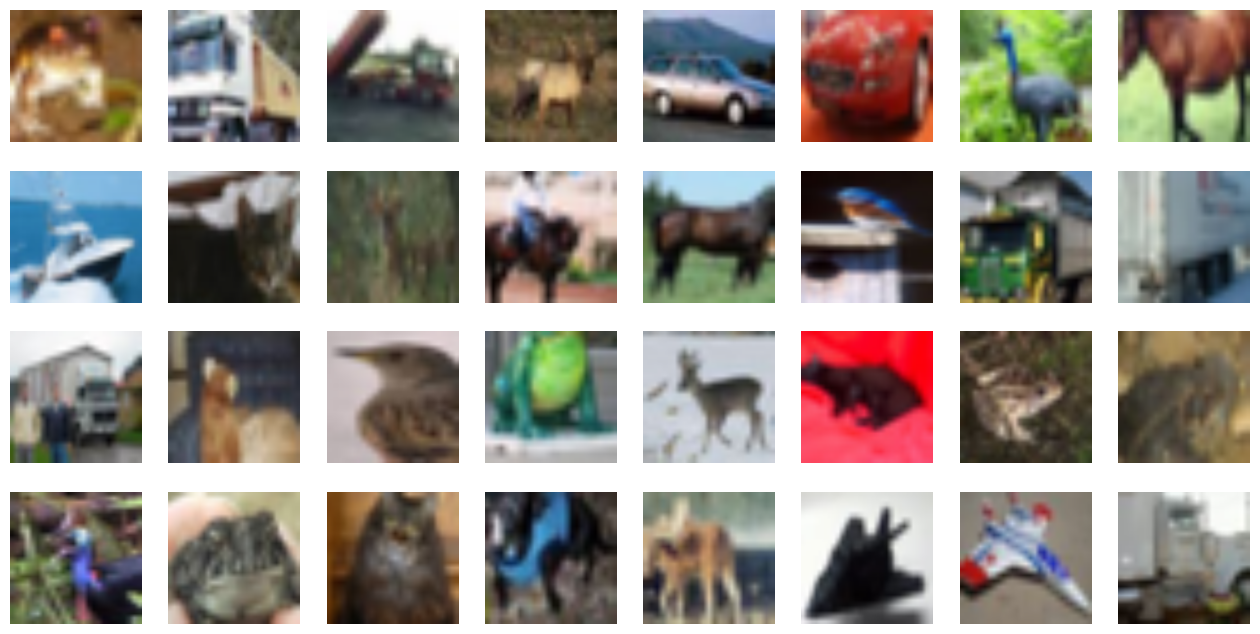

In [ ]:
def imshow(img):
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to HWC format
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to valid range [0, 1]
    plt.imshow(img)
    plt.axis('off')

# show some training images with shuffle=False and labels
train_loader_no_shuffle = DataLoader(half_train_set, batch_size=128, shuffle=False)
data_iter = iter(train_loader_no_shuffle)
images, labels = next(data_iter)

plt.figure(figsize=(16, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])
plt.show()

print(f'Labels are: {labels}')

train_loader_with_aug = DataLoader(train_set, batch_size=128, shuffle=False)
data_iter_aug = iter(train_loader_with_aug)
images_aug, labels_aug = next(data_iter_aug)

plt.figure(figsize=(16, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    imshow(images_aug[i])
plt.show()

train_loader_shuffle = DataLoader(train_set, batch_size=128, shuffle=True)
data_iter_shuffle = iter(train_loader_shuffle)
images_shuffle, labels_shuffle = next(data_iter_shuffle)

For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [ ]:
MODEL_SAVE_PATH = './model.pt'

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    model.train() if train_mode else model.eval()

    epoch_losses = []

    # Disable gradient calculation for validation to save memory
    torch.set_grad_enabled(train_mode)

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())

    return epoch_losses

def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch, printing progress and accuracy.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    model.to(device)

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        model.train()
        train_epoch_losses = []
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_loader), desc='Training', unit='batch') as pbar:
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                train_epoch_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs, dim=1)
                correct_train += (predicted == targets).sum().item()
                total_train += targets.size(0)

                pbar.update(1)

        avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
        train_losses.append(avg_train_loss)
        train_accuracy = 100.0 * correct_train / total_train
        print(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy}')

        model.eval()
        val_epoch_losses = []
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_epoch_losses.append(loss.item())
                    _, predicted = torch.max(outputs, dim=1)
                    correct_val += (predicted == targets).sum().item()
                    total_val += targets.size(0)

                    pbar.update(1)

        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        val_accuracy = 100.0 * correct_val / total_val
        print(f'Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:0.4f}')

    return train_losses, val_losses

def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = 100.0 * correct / total
    return accuracy

def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [ ]:
def conv_bn(inp, oup, stride):
    '''
    Define a standard convolutional layer with batch normalization and ReLU activation
    Parameters:
    inp: Number of input channels
    oup: Number of output channels
    stride: Stride size for the convolution
    '''
    return nn.Sequential(
        nn.Conv2d(
            in_channels=inp,
            out_channels=oup,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        ),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    '''
    Define a depthwise separable convolution layer
    Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    Parameters:
    inp: Number of input channels
    oup: Number of output channels
    stride: Stride size for the depthwise convolution
    '''
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(
            in_channels=inp,
            out_channels=inp,  # Number of filters matches the input channels
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=inp,  # Each channel is convolved independently
            bias=False
        ),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        # Pointwise convolution
        nn.Conv2d(
            in_channels=inp,
            out_channels=oup,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        ),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Now please create your model.

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, stride=2),
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),
            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [ ]:
epochs = 20
lr = 1e-3

model = MobileNet(n_class=10)

if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f'Loaded model from {MODEL_SAVE_PATH}')
else:
    print('No saved model found. Starting training.')

start_time = time.time()
train_losses, val_losses = train(train_loader, test_loader, model, epochs, lr)

torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f'Model saved to {MODEL_SAVE_PATH}')
end_time = time.time()
print("Process Train time: {} s".format(end_time - start_time))

No saved model found. Starting training.
Epoch 1/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.6433 | Train Accuracy: 38.776


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.5961 | Val Accuracy: 44.5800
Epoch 2/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.3021 | Train Accuracy: 53.256


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.3217 | Val Accuracy: 53.7700
Epoch 3/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.1421 | Train Accuracy: 59.356


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.1844 | Val Accuracy: 59.0000
Epoch 4/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.0034 | Train Accuracy: 64.356


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.0152 | Val Accuracy: 65.1600
Epoch 5/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.9100 | Train Accuracy: 68.016


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.9928 | Val Accuracy: 64.3900
Epoch 6/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.8246 | Train Accuracy: 70.844


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.8945 | Val Accuracy: 69.5200
Epoch 7/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.7475 | Train Accuracy: 73.696


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.7819 | Val Accuracy: 73.4000
Epoch 8/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.6847 | Train Accuracy: 75.92


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.6769 | Val Accuracy: 76.5100
Epoch 9/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.6316 | Train Accuracy: 77.676


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.6374 | Val Accuracy: 77.7600
Epoch 10/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.5837 | Train Accuracy: 79.564


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.6246 | Val Accuracy: 78.8300
Epoch 11/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.5398 | Train Accuracy: 81.108


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.6256 | Val Accuracy: 78.5900
Epoch 12/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.5081 | Train Accuracy: 82.136


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5848 | Val Accuracy: 80.6800
Epoch 13/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.4778 | Train Accuracy: 83.26


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5669 | Val Accuracy: 80.6700
Epoch 14/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.4468 | Train Accuracy: 84.392


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5458 | Val Accuracy: 81.6800
Epoch 15/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.4302 | Train Accuracy: 84.94


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5397 | Val Accuracy: 82.0300
Epoch 16/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.4079 | Train Accuracy: 85.804


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5822 | Val Accuracy: 80.9200
Epoch 17/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.3810 | Train Accuracy: 86.648


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5345 | Val Accuracy: 82.3600
Epoch 18/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.3549 | Train Accuracy: 87.452


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5270 | Val Accuracy: 83.3400
Epoch 19/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.3371 | Train Accuracy: 88.336


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5228 | Val Accuracy: 83.5500
Epoch 20/20


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 0.3292 | Train Accuracy: 88.392


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 0.5199 | Val Accuracy: 83.7300
Model saved to ./model.pt
Process Train time: 3301.541653394699 s


Get some metrics and plot your losses.

Batch_size=128, epochs=20, lr=0.001
Val accuracy = 83.73
Process validation time: 28.8117 s


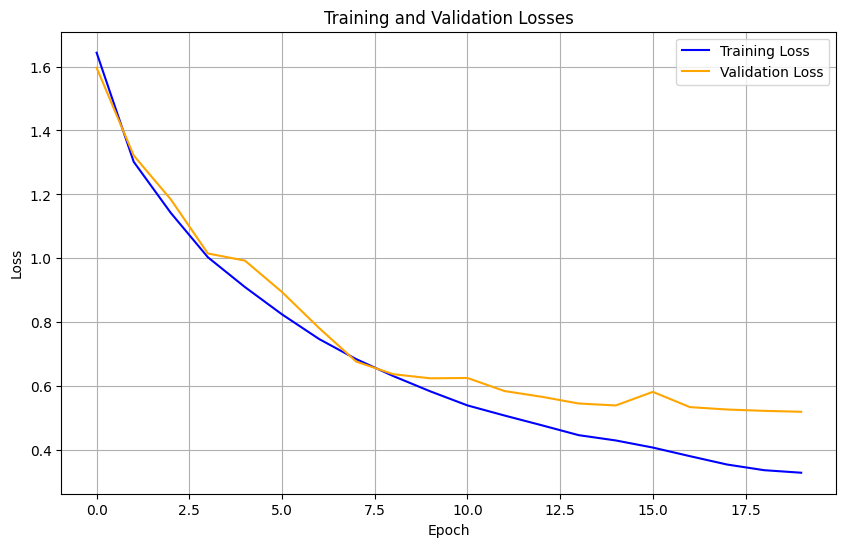

In [ ]:
start = time.time()
val_acc = get_acc(model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print('Process validation time: {:0.4f} s'.format(end - start))

plot_losses(train_losses, val_losses)

### **The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.**

The number of calculation are described abov completely

Speedup = $\frac{h * w * k^2 * Cin * Cout}{h * w * k^2 * Cin + h * w * Cin * Cout}$ = $\frac{k^2 * Cout}{k^2 + Cout}$

For example:

- k = 3

- Cin = Cout = 64

So the speedup is about 7.9 as expected.



## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Epoch 1/2


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.9355 | Train Accuracy: 26.448


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.8662 | Val Accuracy: 29.8300
Epoch 2/2


Training:   0%|          | 0/196 [00:00<?, ?batch/s]

Train Loss: 1.6958 | Train Accuracy: 36.56


Validation:   0%|          | 0/79 [00:00<?, ?batch/s]

Val Loss: 1.6704 | Val Accuracy: 37.9600
Process Train time: 491.5483808517456 s


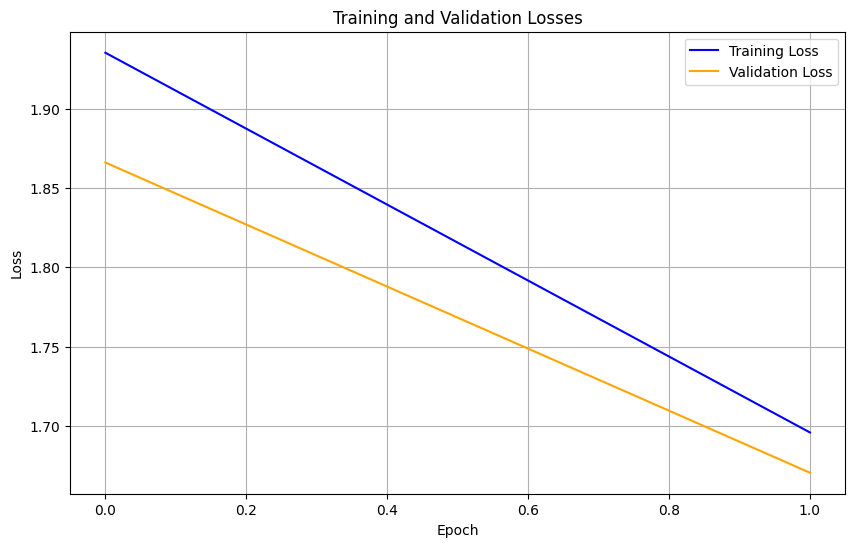

In [ ]:
epochs = 2
cnn_model = NormalCNN(n_class=10)

start_time = time.time()
train_losses, val_losses = train(train_loader, test_loader, cnn_model, epochs, lr)
end_time = time.time()
print('Process Train time: {} s'.format(end_time - start_time))

plot_losses(train_losses, val_losses)

Batch_size=128, epochs=2, lr=0.001
Val accuracy = 37.96
Process validation time: 37.6985 s


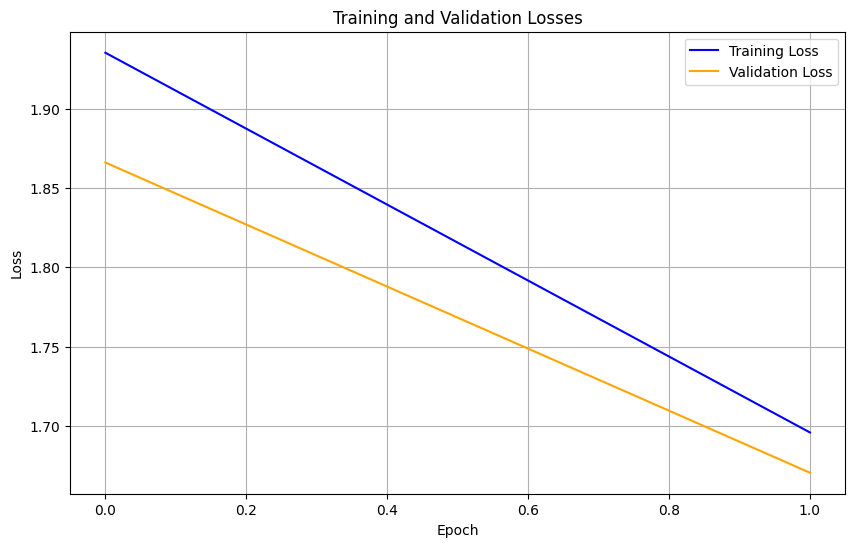

In [ ]:
start = time.time()
val_acc = get_acc(cnn_model, test_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print('Process validation time: {:0.4f} s'.format(end - start))

plot_losses(train_losses, val_losses)

### **Compare speed of learning and validating in normal CNN vs MobileNet:**

Training Mobile net for 20 epochs takes **3300** seconds and validating takes **29** seconds.

But normal CNN takes **491** seconds in training for 2 epochs and validation takes **38** seconds. approximately trainig for 20 epochs should takes **9820** seconds which is more than double the Mobilenet.

As expected MobileNet is much faster than normal CNN.

In [ ]:
# Compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of normal CNN parameters: {count_parameters(cnn_model)}')
print(f'Total number of MobileNet parameters : {count_parameters(model)}')

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters : 3217226


### **Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.**

The resolution multiplier $\rho$ scales the spatial dimensions of the input image during training and prediction. This makes Cin much smaller which affects parametes according to formula above.


### **Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?**

Still number of parametes is still important because they need more memory for GPUs and this can limit the the size of model to fit on a GPU or a cluster and makes the training time so long.

Also they are slower at predicting which is important for real time applications.

Sometimes sum models should run on devices with limited power and resource like mobile devices.

Also larger model requires more power consumption.

Besides resources model with high parameters has more risk to overfitting.

Even though powerful GPUs has limited memory bandwith and transfer speed which are bottlenecks.